# Система уравнений и численная схема

Собственно, система уравнений мелкой воды:  

$\eta_t + ((\eta + x) u)_x = 0,$  
$u_t + \eta_x + (\frac{u^2}{2})_x= 0$

Пробуем численно решить систему с помощью схемы:  

$\frac{\eta_n^{m+1} - \eta_n^{m}}{\tau} + max(0, \eta) \frac{u_n^m - u_{n-1}^m}{h} +
 min(0, \eta) \frac{u_{n+1}^m - u_n^m}{h} + max(0, u) \frac{\eta_n^m - \eta_{n-1}^m}{h} +
 min(0, u) \frac{\eta_{n+1}^m - \eta_n^m}{h} + u + max(0, x) \frac{u_n^m - u_{n-1}^m}{h} +
 min(0, x) \frac{u_{n+1}^m - u_n^m}{h} = 0,$  
$\frac{u_n^{m+1} - u_n^m}{\tau} + \frac{\eta_{n+1}^m - \eta_n^m}{h} + max(0, u) \frac{u_n^m - u_{n-1}^m}{h} +
 min(0, u) \frac{u_{n+1}^m - u_n^m}{h} = 0$  
 
 Преобразуем схему:  
 
$\eta_n^{m+1} = (1 - \frac{\tau}{h} |u_n^m|) \eta_n^m - (\tau + \frac{\tau}{h} (|\eta_n^m| + |x|)) u_n^m -
 \frac{\tau}{h} ((min(0, \eta_n^m) + min(0, x)) u_{n+1}^m - (max(0, \eta_n^m) + max(0, x)) u_{n-1}^m +
 min(0, u_n^m) \eta_{n+1}^m - max(0, u_n^m) \eta_{n-1}^m)$  
$u_n^{m+1} = (1 - \frac{\tau}{h} |u_n^m|) u_n^m - \frac{\tau}{h} ((\eta_n^m - \eta_{n-1}^m) +
 min(0, u_n^m) u_{n+1}^m - max(0, u_n^m) u_{n-1}^m)$  
 
 !!!To do - написать схемы на границах; написать про дно!!!

# Код

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
def solve_eq(h, tau, x_range, t_range, u0, eta0):
    """Функция считает схему, указанную выше.
    
        u0, eta0 - начальные условия
        x_range - пара чисел, задающая границы изменения по x
        t_range - пара чисел, задающая границы изменения по t
        h - шаг по x
        tau - шаг по t
        
       Схема явная - каждый следующий шаг по времени вычисляется из предыдущего"""
    
    # задаём сетку
    x_range = sorted(x_range)
    x = np.arange(x_range[0], x_range[1] + h, h)
    t_range = sorted(t_range)
    t = np.arange(t_range[0], t_range[1] + tau, tau)
    N = x.size
    M = t.size
    
    # создаём сеточные функции и задаём начальные условия с учётом дна - 
    # ищем максимальную по x точку, в которой возвышение меньше дна,
    # во всех точках левее полагаем возвышение равным дну, а скорость - нулю
    u = np.zeros((M, N))
    u[0] = u0
    eta = np.zeros((M, N))
    eta[0] = eta0
    
    index = -1
    for i, v in enumerate((eta[0] + x)[::-1]):
        if np.abs(v) < 2*h:
            index = i
            break
    index = len(x) - index
    if 0 < index < len(x):
        eta[0][:index] = -x[:index]
        u[0][:index] = np.zeros(index)
    
    # Вспомогательные конструкции
    f = tau/h
    u_max = []
    u_min = []
    eta_max = []
    eta_min = []
    x_max = np.maximum(0, x)
    x_min = np.minimum(0, x)
    
    # находим u
    for m in range(0, M-1):
        # Здесь используем соотношения между |y|, max(0, y) и min(0, y)
        u_max = np.maximum(0, u[m])
        u_min = np.minimum(0, u[m])
        eta_max = np.maximum(0, eta[m])
        eta_min = np.minimum(0, eta[m])
        
        eta[m+1] = ((1 - f*np.abs(u[m]))                   * eta[m]              -
                    (tau + f*(np.abs(eta[m]) + np.abs(x))) * u[m]                -
                    f*(eta_min + x_min)                    * np.roll(u[m], -1)   +
                    f*(eta_max + x_max)                    * np.roll(u[m], 1)    -
                    f*u_min                                * np.roll(eta[m], -1) +
                    f*u_max                                * np.roll(eta[m], 1))
        
        u[m+1] = (f*(eta[m] - np.roll(eta[m], 1))                     -
                  (1 - f*np.abs(u[m]))            * u[m]              -
                  f*u_min                         * np.roll(u[m], -1) +
                  f*u_max                         * np.roll(u[m], 1))
        
        # Задаём значения на правой границе
        eta[m+1][N-1] = (eta[m][N-1] - 
                         (tau + f*(2*eta[m][N-1] - eta[m][N-2] + x[N-1])) * u[m][N-1] +
                         f*(eta[m][N-1] + x[N-1])                         * u[m][N-2])
        
        u[m+1][N-1] = ((1 - f*(u[m][N-1] - u[m][N-2])) * u[m][N-1] -
                       f*(eta[m][N-1] - eta[m][N-2]))
        
        # Задаём значения на левой границе
        eta[m+1][0] = (eta[m][0]                                             - 
                       (tau + f*(-2*eta[m][0] + eta[m][1] - x[0])) * u[m][0] -
                       f*(eta[m][0] + x[0])                        * u[m][1])
        
        u[m+1][0] = ((1 - f*(u[m][1] - u[m][0])) * u[m][0] -
                     f*(eta[m][1] - eta[m][0]))
        
        # Поправляем возвышение свободной поверхности и скорость с учётом дна - 
        # ищем максимальную по x точку, в которой возвышение меньше дна,
        # во всех точках левее полагаем возвышение равным дну, а скорость - нулю
        index = -1
        for i, v in enumerate((eta[m+1] + x)[::-1]):
            if np.abs(v) < 2*h:
                index = i
                break
        index = len(x) - index
        if 0 < index < len(x):
            eta[m+1][:index] = -x[:index]
            u[m+1][:index] = np.zeros(index)
    
    return eta, u

# Графики численных решений

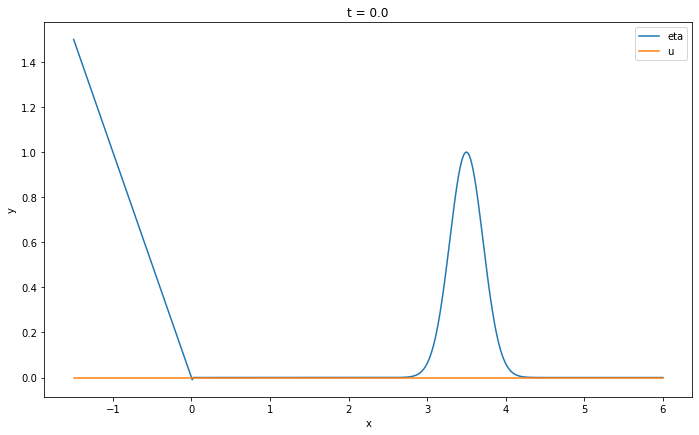

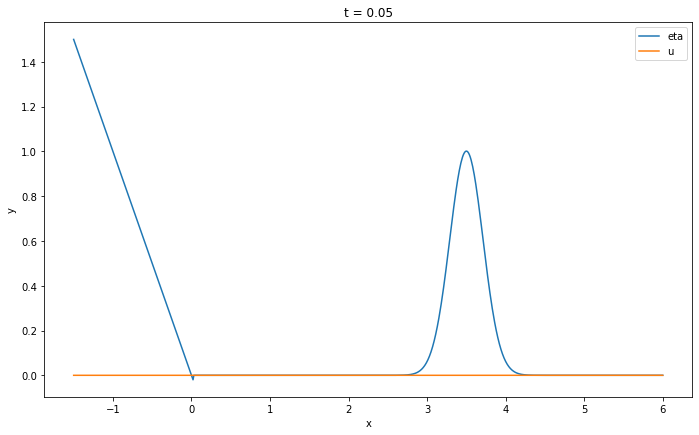

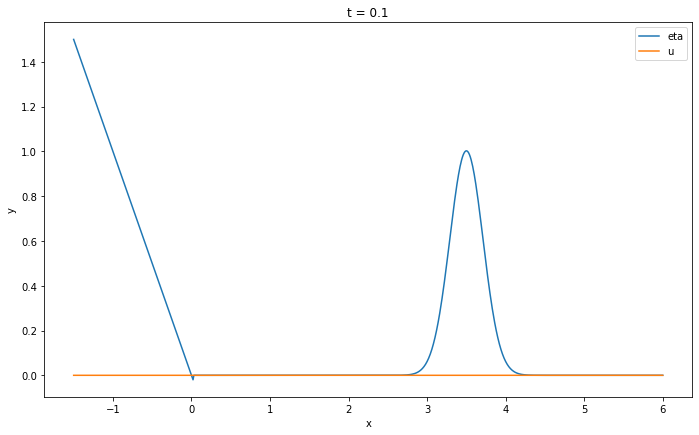

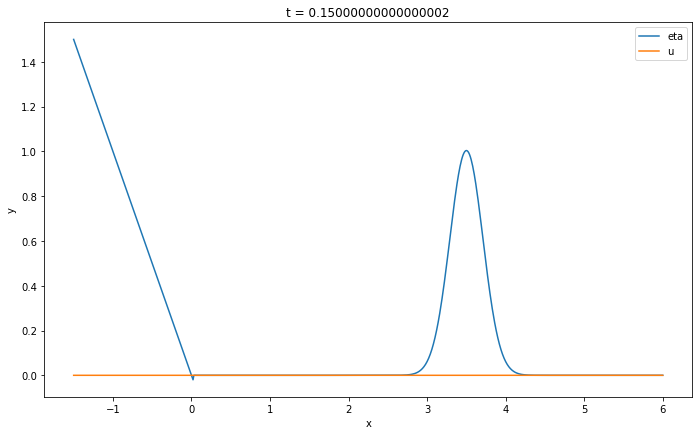

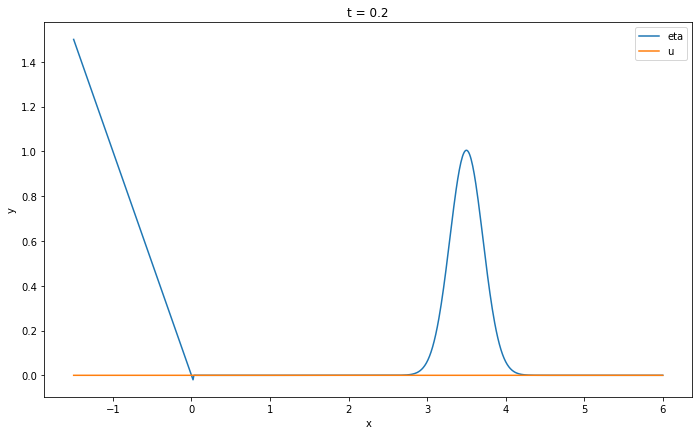

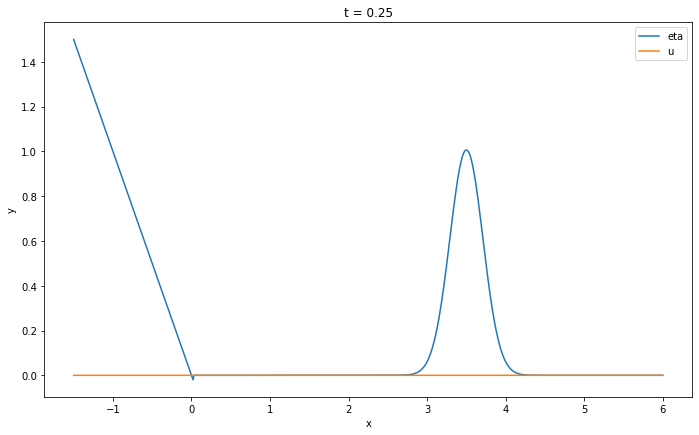

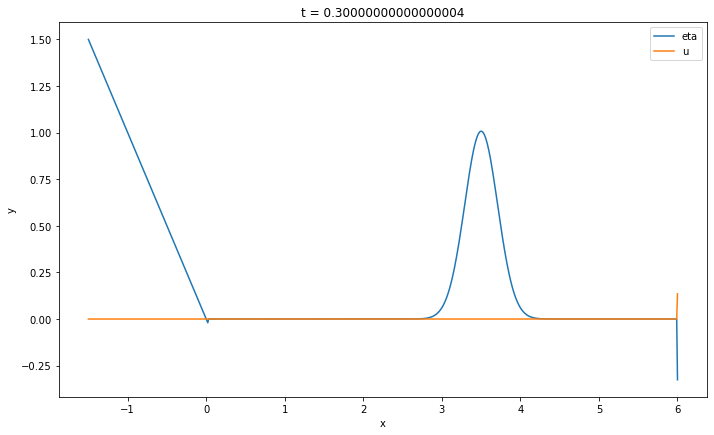

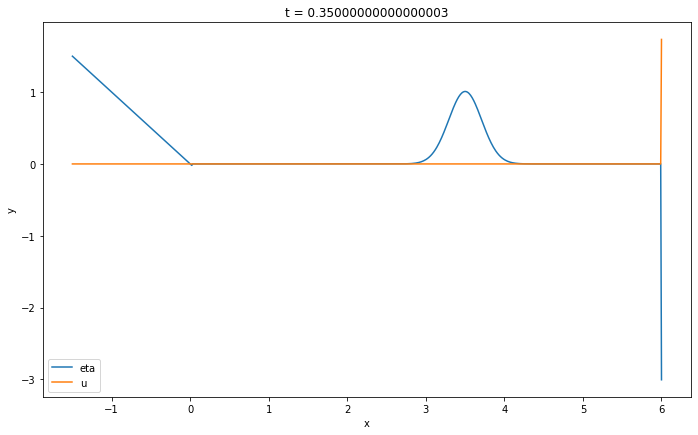

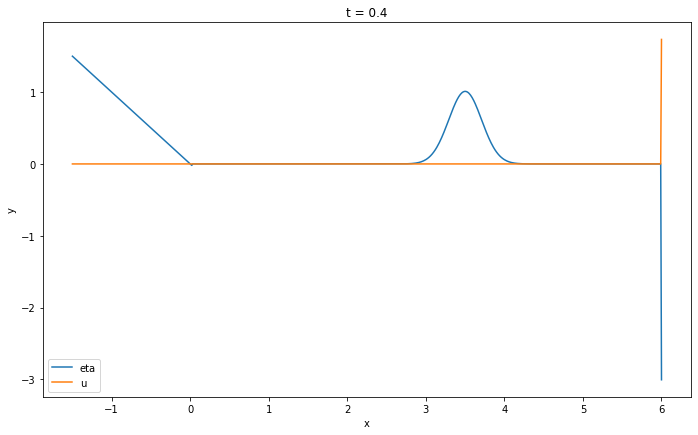

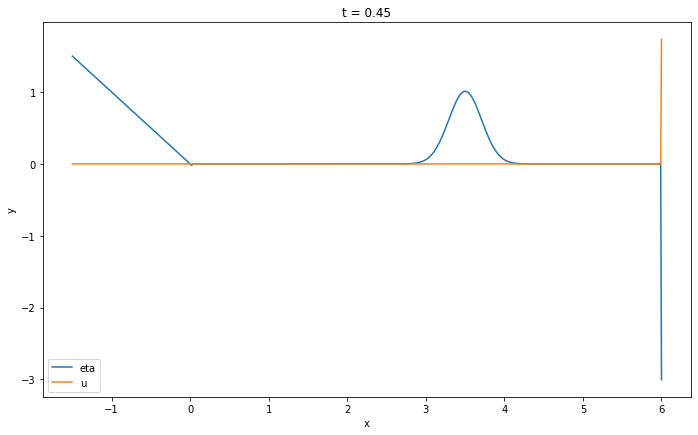

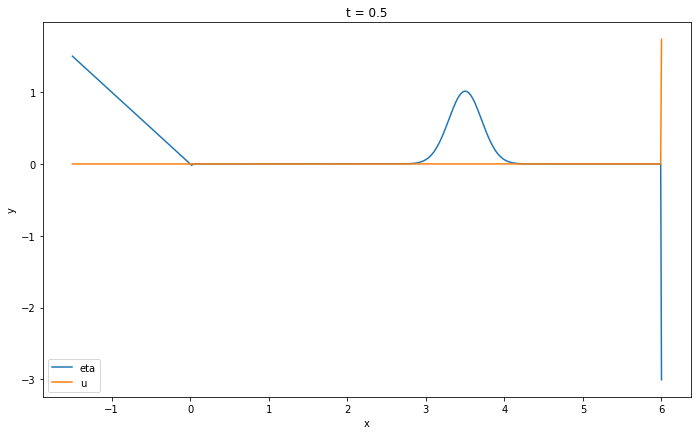

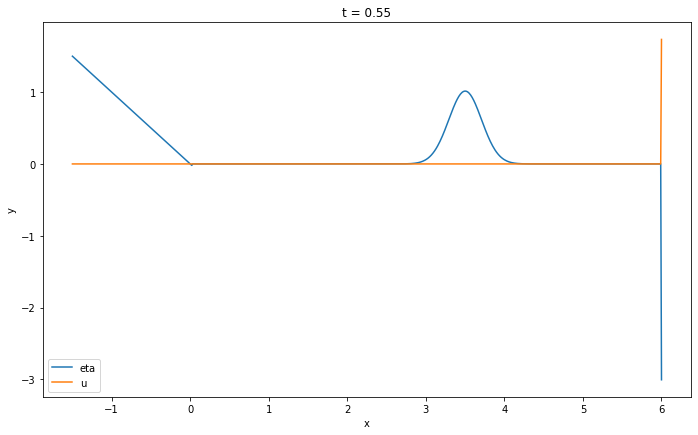

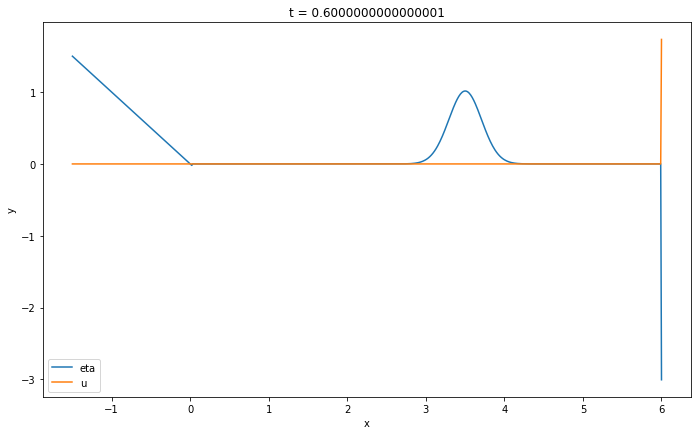

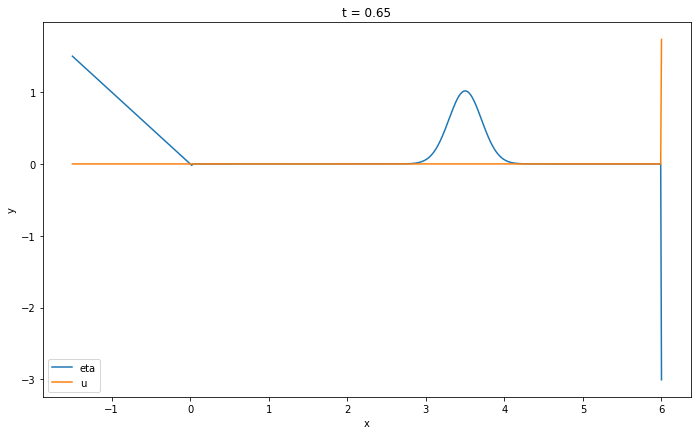

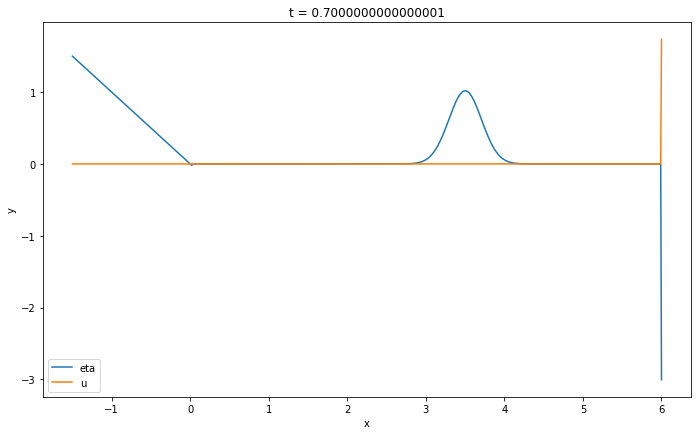

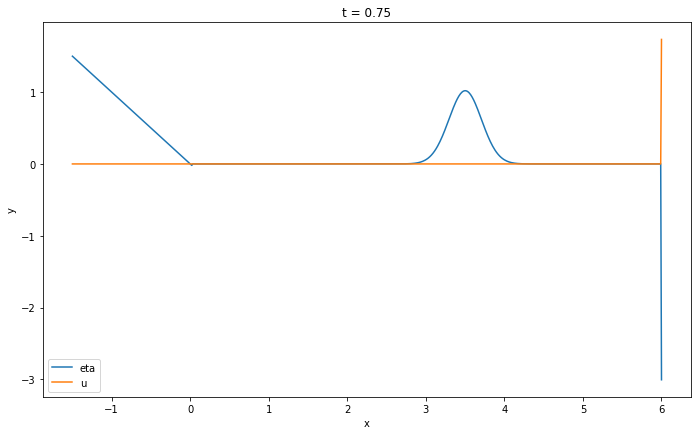

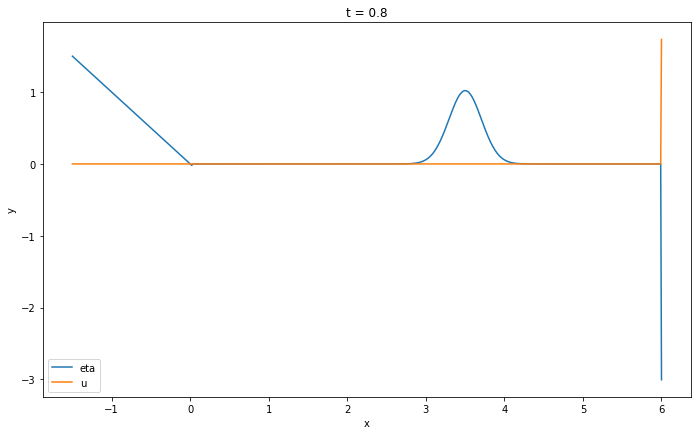

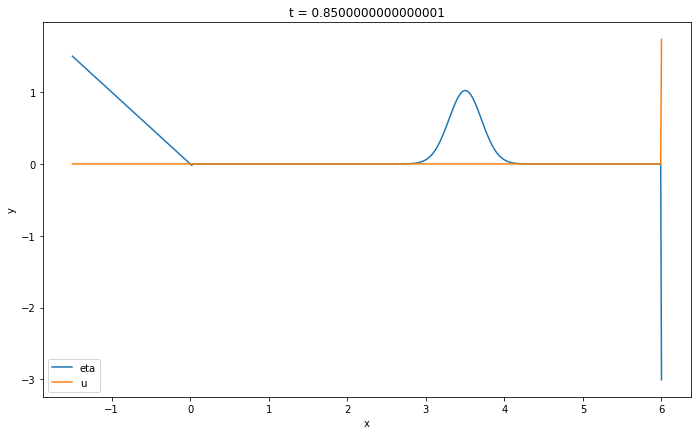

In [133]:
# задаём сетку
h = 0.01
tau = 0.0005
x_range = (-1.5, 6.0)
x = np.arange(x_range[0], x_range[1] + h, h)
t_range = (0.0, 1.0)
t = np.arange(t_range[0], t_range[1] + tau, tau)

# задаём начальные условия
u0 = np.zeros(len(x))
#u0 = np.exp(-np.power((x-3.5)/0.3, 2))
#u0 = -np.ones(len(x))
eta0 = np.exp(-np.power((x-3.5)/0.3, 2))

# численно решаем уравнение
eta_num, u_num = solve_eq(h, tau, x_range, t_range, u0, eta0)

# строим графики
time_step = 0.05
final_time = 0.9
i = 0
while (i*time_step)/tau < final_time/tau:
    fig = plt.figure()
    axes = fig.add_axes([0.0, 2.0, 1.5, 1.3])
    axes.plot(x, eta_num[round((i*time_step)/tau)], label='eta')
    axes.plot(x, u_num[round((i*time_step)/tau)], label='u')
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.set_title('t = ' + str(t_range[0] + i*time_step))
    axes.legend(loc=0)
    i += 1